In [143]:
from typing import List
from math import sqrt
import numpy as np
from scipy.sparse.linalg import norm
from scipy.constants import pi
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import cirq
import openfermion as of
from kcommute import get_si_sets
from convert import to_groups_of

In [144]:
def krylov_energy_bound(
    d: int,
    norm_h: float,
    chi: float,
    zeta: float,
    gamma0_sq: float,
    delta: float,
    eps: float,
    s_dist: float
) -> float:
    """Error bound from Kirby's thm. See Eq. 50.

    Arguments:
    d - subspace dimension.
    norm_h - Norm of Hamiltonian matrix (in full basis, not subspace).
    chi - chi from Kirby's equation.
    zeta - zeta from Kirby's equation.
    gamma0_sq - |<reference | ground state>|^2.
    delta - energy gap of the Hamiltonian.

    Returns:
    upper bound on error in ground state energy."""

    assert chi >= 0.0
    assert zeta >= 0.0

    gamma0_sq_p = gamma0_sq - 2.0 * eps - 2 * s_dist
    if gamma0_sq_p < 0.0:
        print("gamma0_sq_p is negative.")
    delta_p = delta - chi / gamma0_sq_p

    if chi / gamma0_sq_p > delta_p / 2.0:
        print("!!! chi / gamma0_sq_p > delta_p / 2")
        print(f"gamma0_sq_p = {gamma0_sq_p}")
        print(f"chi = {chi}")
        print(f"Delta'/2 = {delta_p / 2.0}")

    t1 = 2 * chi / delta_p
    t2 = zeta
    t3 = 8.0 * ((1 + (pi * delta_p) / (4 * norm_h)) ** (-2.0 * d))
    p1 = chi / gamma0_sq_p
    p2 = (6 * norm_h) / gamma0_sq_p
    return p1 + p2 * (t1 + t2 + t3)


def first_order_comm_norm(
    groups: List[of.QubitOperator],
    nq: int
) -> float:
    """Norm of commutators from first-order Trotter bound in ToTECS Proposition 9.

    Arguments:
    groups: A list of qubit operators. Each represents a term in the Trotter expansion.

    Returns:
    Sum of commutator norms from Prop. 9."""

    # Evaluate sum_gamma1 ||[\sum_gamma2 H_gamma2, H_gamma1]||
    comm_norms = 0.0 # = sum_gamma1 ||\sum_gamma2 [H_gamma2, H_gamma1]||
    if len(groups) > 1:
        for i1 in range(len(groups)):
            total_commutator = of.QubitOperator() # = \sum_gamma2 [H_gamma2, H_gamma1]
            for i2 in range(i1 + 1, len(groups)):
                total_commutator += groups[i2] * groups[i1] - groups[i1] * groups[i2]
            tc_matrix = of.linalg.qubit_operator_sparse(total_commutator, nq)
            comm_norms += norm(tc_matrix, ord=2)
    return comm_norms


def s_dist_bound(d: int, tau: float, r: int, comm_norm: float) -> float:
    """Upper bound on ||S-S'|| from Trotter error.
    
    Arguments:
    d - subspace dimension.
    tau - evolution time
    r - number of time steps.
    comm_norm - sum of commutator norms.
    
    Returns:
    upper bound on ||S-S'||."""

    return d ** 2 * tau ** 2 / (sqrt(2.0) * r) * comm_norm

In [145]:
l = 2
t = 1.0
u = 2.0
ham_fermi = of.hamiltonians.fermi_hubbard(l, l, t, u, spinless=True)
ham = of.transforms.jordan_wigner(ham_fermi)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham)
nq = of.utils.count_qubits(ham)

if l == 2:
    delta = 3.23
else:
    raise ValueError(f"No energy gap known for value l = {l}")

tau = 0.1
d = 16
eps = 1e-4
steps = range(10, 300)
gamma0_sq = 0.99

# Get bound on the S matrix error.
# groups = get_si_sets(ham_cirq, k=1)
groups = [[p] for p in ham_cirq]
groups_of = to_groups_of(groups)
comm_norm = first_order_comm_norm(groups_of, nq)
s_distance = [s_dist_bound(d, tau, s, comm_norm) for s in steps]

# Compute the bound for each.
h_norm = norm(of.linalg.get_sparse_operator(ham))
print(f"h_norm = {h_norm}")
bounds = []
for sd in s_distance:
    chi = 2.0 * h_norm * sd
    zeta = 2.0 * d * (eps + sd)
    bound = krylov_energy_bound(d, h_norm, chi, zeta, gamma0_sq, delta, sd, sd)
    bounds.append(bound)

h_norm = 13.2664991614216
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.

In [146]:
print("mean", np.average(bounds))
print("median", np.median(bounds))
print("max", np.max(bounds))
print("min", np.min(bounds))

mean 5.301315656965383e+67
median -924.7641590707522
max 1.5373630298267303e+70
min -266917.6006000837


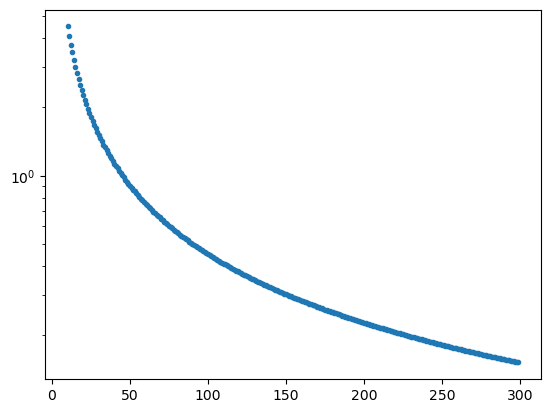

In [147]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(steps, s_distance, '.')

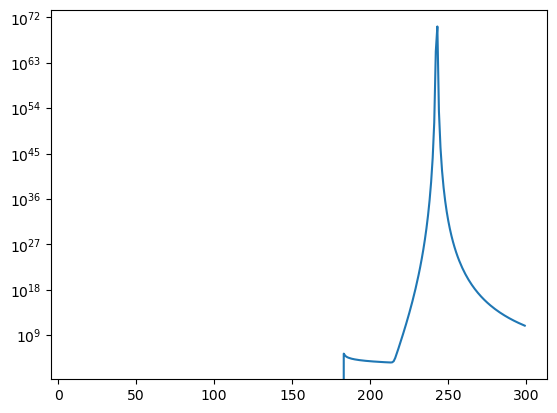

In [148]:
fig2, ax2 = plt.subplots()
ax2.set_yscale("log")
ax2.plot(steps, bounds)
# plt.ylim(-10.0, 20.0)

In [ ]:
def krylov_energy_bound_general(
    d: int,
    norm_h: float,
    chi: float,
    zeta: float,
    gamma0_sq_p: float,
    delta: float,
    eps: float,
    s_dist: float,
    little_delta: float,
    little_delta_p: float
) -> float:
    """Error bound from Kirby's thm. See Eq. 50.

    Arguments:
    d - subspace dimension.
    norm_h - Norm of Hamiltonian matrix (in full basis, not subspace).
    chi - chi from Kirby's equation.
    zeta - zeta from Kirby's equation.
    gamma0_sq - |<reference | ground state>|^2.
    delta - energy gap of the Hamiltonian.

    Returns:
    upper bound on error in ground state energy."""

    assert chi >= 0.0
    assert zeta >= 0.0

    if gamma0_sq_p < 0.0:
        print("gamma0_sq_p is negative.")
    delta_p = delta - chi / gamma0_sq_p

    t1 = chi / (little_delta_p - little_delta)
    t2 = zeta
    t3 = 8.0 * ((1 + (pi * little_delta) / (2 * norm_h)) ** (-2.0 * d))
    if little_delta_p > delta_p:
        p0 = little_delta_p
    else:
        p0 = 0
    p1 = chi / gamma0_sq_p
    p2 = (6 * norm_h) / gamma0_sq_p
    return p0 + p1 + p2 * (t1 + t2 + t3)

In [159]:
# Compute the bound for each.
h_norm = norm(of.linalg.get_sparse_operator(ham))
print(f"h_norm = {h_norm}")
bounds = []
for sd in s_distance:
    chi = 2.0 * h_norm * sd
    zeta = 2.0 * d * (eps + sd)
    gamma0_sq_p = gamma0_sq - 2.0 * eps - 2 * sd
    # Find little delta, little delta prime that maximize the bound,
    # s.t. chi/gamma0_sq_p < little delta prime - little delta
    callback = lambda little_delta, little_delta_p: -1.0 * krylov_energy_bound_general(d, h_norm, chi, zeta, gamma0_sq_p, delta, sd, sd, little_delta, little_delta_p)
    constraint_fun = lambda little_delta, little_delta_p: little_delta_p - little_delta - (chi / gamma0_sq_p)
    little_delta = 1.0
    v0 = np.array([little_delta, chi / gamma0_sq_p - little_delta])
    result = minimize(lambda v: callback(v[0], v[1]), v0, constraints={'type': 'ineq', 'fun': lambda v: constraint_fun(v[0], v[1])})
    if not result.success:
        print(f"||S-S'||= {sd}: Optimization did not succeed.")
    bound = result.fun
    bounds.append(bound)

h_norm = 13.2664991614216
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.
gamma0_sq_p is negative.

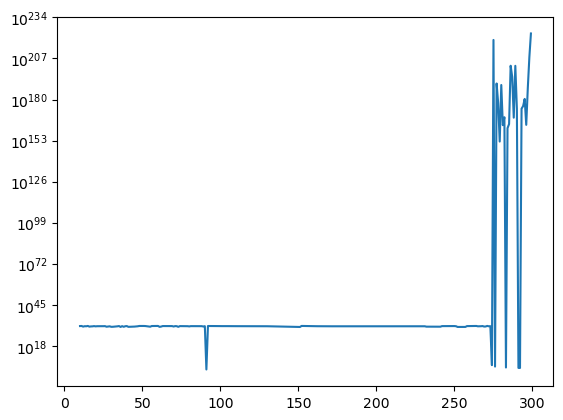

In [162]:
fig3, ax3 = plt.subplots()
ax3.set_yscale("log")
ax3.plot(steps, abs(np.array(bounds)))